<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.6.0


## Load and Preprocess the Data

In [2]:
#load train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
#normalize pixel value
X_train = X_train.astype(np.float32)/255.0
X_test = X_test.astype(np.float32)/255.0

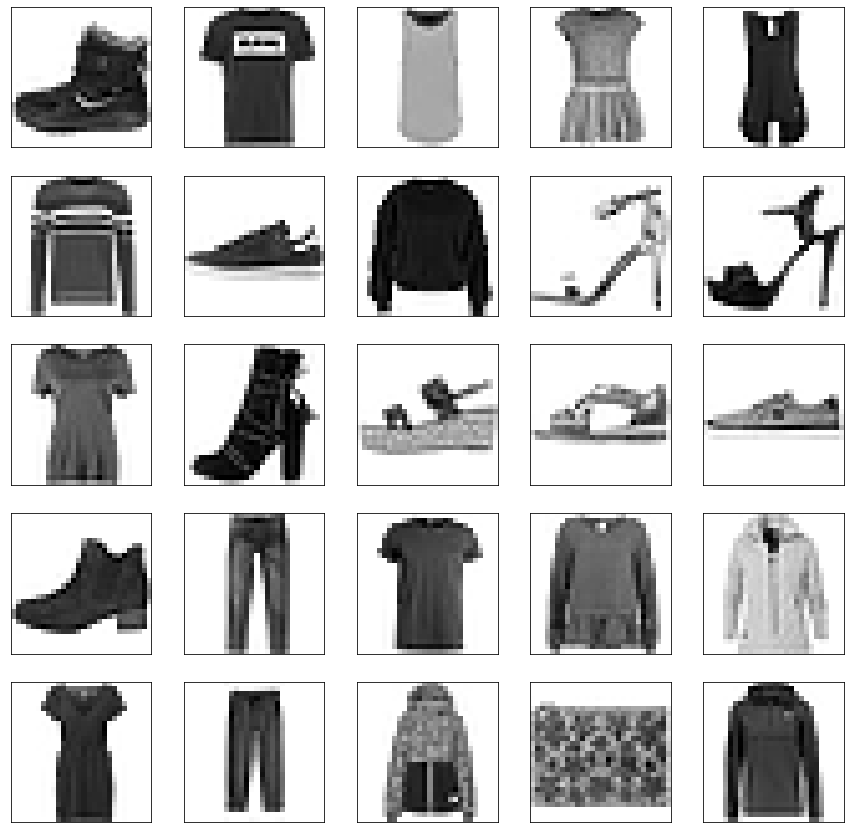

In [4]:
#view samples
plt.figure(figsize=(15, 15))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)

plt.show()

## Create Batches of Training Data

In [5]:
batch_size = 32

#create dataset using X_train
#this dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)

#combines consecutive elements of this dataset into batches
#drop_remainder = ignore the last batch to allow full shape propagation
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Build the Generator Network for DCGAN

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [6]:
#set number of features
num_features = 100

#create generator
generator = keras.models.Sequential([keras.layers.Dense(7*7*128, input_shape=[num_features]), #(7*7*128) is number of units
                                     keras.layers.Reshape([7, 7, 128]), 
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', activation='selu'), #num units, filter, stride | selu is recommended for DCGAN
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding='same', activation='tanh')])

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

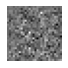

In [8]:
#create vector of random noise to pass through the generator to see what the output is without the network having been trained
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)

#plot image
plot_utils.show(generated_image, 1)

## Build the Discriminator Network for DCGAN

In [9]:
#create discriminator (which is a CNN-based image classifier)
discriminator = keras.models.Sequential([keras.layers.Conv2D(64, (5, 5), (2, 2), padding='same', input_shape=[28, 28, 1]),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Conv2D(128, (5, 5), (2, 2), padding='same'),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation='sigmoid')])

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [11]:
#create noise
decision = discriminator(generated_image)

#if closer to 0 ~ fake, if closer to 1 ~ real
print(decision)

tf.Tensor([[0.49818662]], shape=(1, 1), dtype=float32)


## Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [12]:
#compile
discriminator.compile(loss='binary_crossentropy',
                      optimizer='rmsprop')

#specify that discriminator is not trainable as default because we only want to train generator at first
discriminator.trainable = False

#create GAN
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy',
            optimizer='rmsprop')

## Define Training Procedure

In [13]:
#create seed image
seed = tf.random.normal(shape=[batch_size,  100])

In [14]:
#first train the discriminator, then train the generator
#sampling mini batches of noise sample from seed, and sampling real samples from training images
#then pass the noise to generator and get the fake images out

#define training procedure
from tqdm import tqdm

def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):

    generator, discriminator = gan.layers

    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        #produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [15]:
#source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
#to create gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train DCGAN

In [16]:
#reshape and scaling
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [17]:
#create batches and shuffle from fashion mnist
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

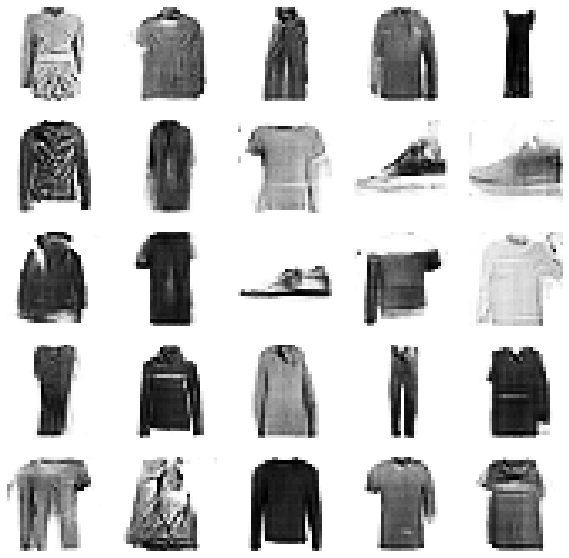

 32%|███▏      | 32/100 [39:49<1:23:48, 73.95s/it]

Epoch 33/100


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=100)

## Generate Synthetic Images with DCGAN

In [ ]:
#pass noise into trained generator
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

In [ ]:
#source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)